<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/Gan_%EC%B2%AB%EA%B1%B8%EC%9D%8C/FashionMnist_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [3]:
class_list = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot']

batch_size = 96

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0, generator=torch.Generator(device=device))

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, generator=torch.Generator(device=device))

100%|██████████| 26421880/26421880 [00:01<00:00, 14944025.60it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274183.36it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5066757.24it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 27717942.22it/s]


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



In [4]:
def imshow(image, label):
    plt.title("label = "+ class_list[label])
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image, interpolation='none', cmap='Blues')

torch.Size([96, 1, 28, 28]) torch.Size([96])


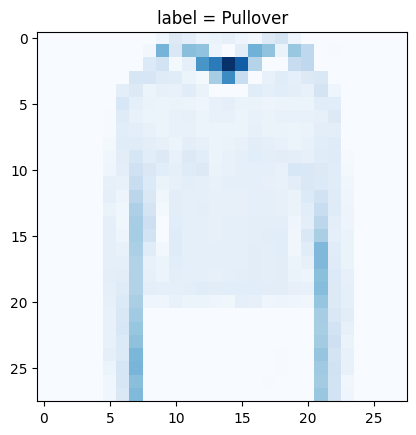

In [5]:
image, label = next(iter(trainloader))
print(image.shape, label.shape)
imshow(image[0,:], label[0])

# Conditional GAN

### 1. 책에서 사용하는 방법
- latent vector size = 1000

In [6]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return torch.cuda.FloatTensor(random_data)


def generate_random_seed(size):
    random_data = torch.randn(size)
    return torch.cuda.FloatTensor(random_data)


def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    for i in range(size[0]):
        random_idx = random.randint(0,size[1]-1)
        label_tensor[i][random_idx] = 1.0
    return torch.cuda.FloatTensor(label_tensor)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784+10, 512), # 레이블 텐서 추가
            nn.LeakyReLU(0.2),
            nn.LayerNorm(512),
            nn.Dropout(0.4),

            nn.Linear(512, 512),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(512),
            nn.Dropout(0.4),

            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        self.loss_function = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, image_tensor, label_tensor):
        # 레이블 텐서 결합
        inputs = torch.cat((image_tensor, label_tensor), dim=1)
        return self.model(inputs)

    def train(self, inputs, label_tensor, targets):
        outputs = self.forward(inputs, label_tensor)
        loss = self.loss_function(outputs, targets)
        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1000+10, 128), #
            nn.LeakyReLU(0.2),
            nn.LayerNorm(128),

            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(256),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(512),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.LayerNorm(1024),

            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        self.counter = 0
        self.progress = []

    def forward(self, seed_tensor, label_tensor):
        inputs = torch.cat((seed_tensor, label_tensor), dim=1) # 텐서 결합
        return self.model(inputs)

    def train(self, D, inputs, label_tensor, targets):
        g_outputs = self.forward(inputs, label_tensor)
        d_outputs = D.forward(g_outputs, label_tensor)
        loss = D.loss_function(d_outputs, targets)

        self.counter += 1
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])

        df.plot(ylim=(0), figsize=(16, 8), alpha=0.5, grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))

    # 주어진 조건에 맞는 이미지 생성 함수
    def plot_images(self, label):
        label_tensor = torch.zeros((1, 10))
        label_tensor[0][label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(self.forward(generate_random_seed((1, 1000)), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')



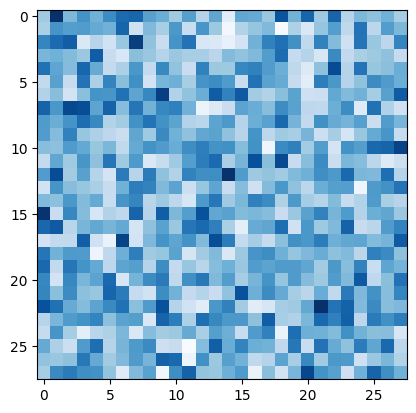

In [ ]:
G = Generator()

output = G.forward(generate_random_seed((1, 1000)), generate_random_one_hot([1, 10]))

img = output.detach().cpu().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')


In [ ]:
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=1010, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (12): Linear(in_features=1024, out_features=784, bias=True)
    (13): Sigmoid()
  )
)

In [ ]:
%%time

# train Discriminator and Generator

epochs = 50
for epoch in range(epochs):
    print("epochs = ", epoch + 1)
    for image_data_tensor, label_tensor in trainloader:
        image_data_tensor = image_data_tensor.view([batch_size, 784])
        label_tensor = nn.functional.one_hot(label_tensor, num_classes=len(class_list))
        image_data_tensor = image_data_tensor.cuda()
        label_tensor = label_tensor.cuda()
        D.train(image_data_tensor, label_tensor, torch.cuda.FloatTensor([[1.0]]*batch_size))
        random_label = generate_random_one_hot([batch_size, 10])
        D.train(G.forward(generate_random_seed((batch_size, 1000)), random_label).detach(), random_label, torch.cuda.FloatTensor([[0.0]]*batch_size))
        G.train(D, generate_random_seed((batch_size, 1000)), generate_random_one_hot([batch_size, 10]), torch.cuda.FloatTensor([[1.0]]*batch_size))

epochs =  1
epochs =  2
epochs =  3
epochs =  4
epochs =  5
epochs =  6
epochs =  7
epochs =  8
counter =  10000
epochs =  9
epochs =  10
epochs =  11
epochs =  12
epochs =  13
epochs =  14
epochs =  15
epochs =  16
counter =  20000
epochs =  17
epochs =  18
epochs =  19
epochs =  20
epochs =  21
epochs =  22
epochs =  23
epochs =  24
counter =  30000
epochs =  25
epochs =  26
epochs =  27
epochs =  28
epochs =  29
epochs =  30
epochs =  31
epochs =  32
counter =  40000
epochs =  33
epochs =  34
epochs =  35
epochs =  36
epochs =  37
epochs =  38
epochs =  39
epochs =  40
counter =  50000
epochs =  41
epochs =  42
epochs =  43
epochs =  44
epochs =  45
epochs =  46
epochs =  47
epochs =  48
counter =  60000
epochs =  49
epochs =  50
CPU times: user 18min 41s, sys: 6.35 s, total: 18min 47s
Wall time: 20min 11s


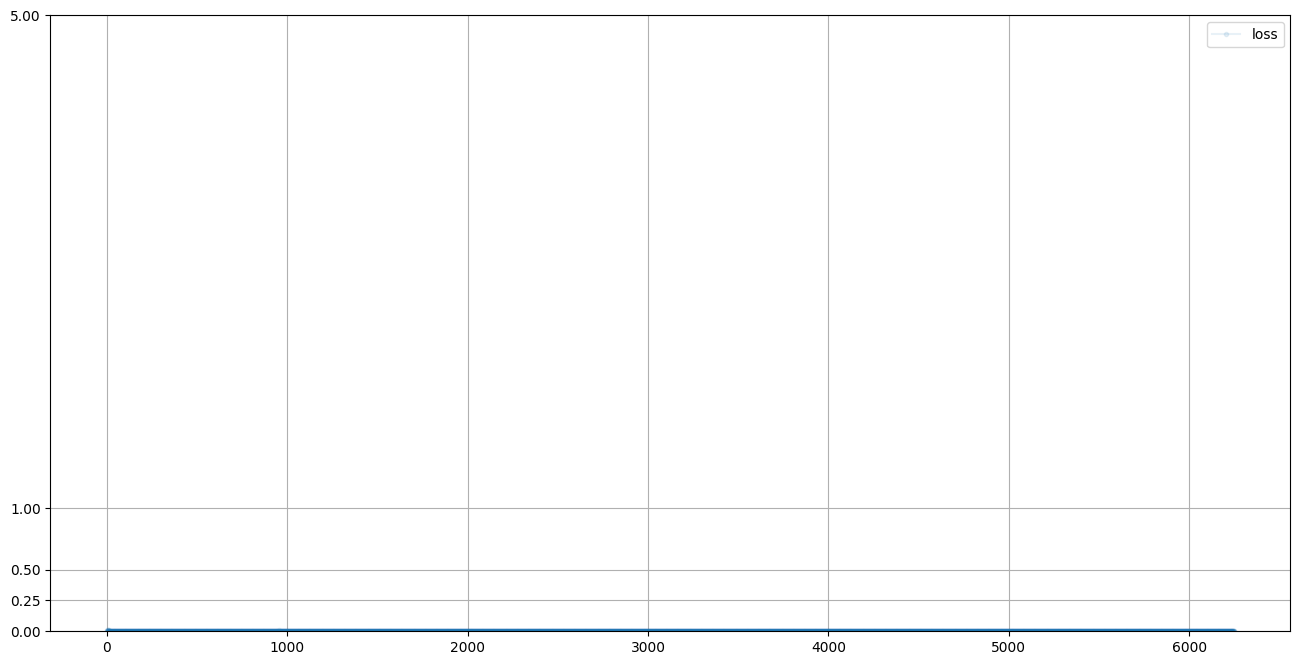

In [ ]:
D.plot_progress()

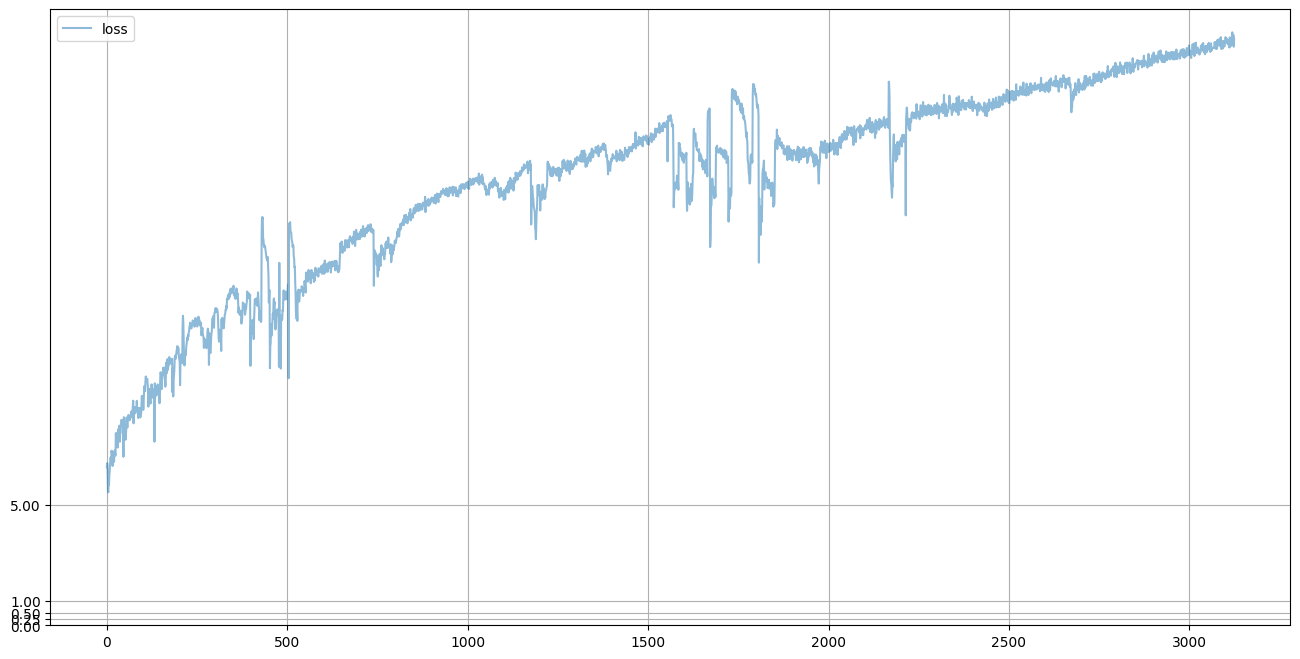

In [ ]:
G.plot_progress()

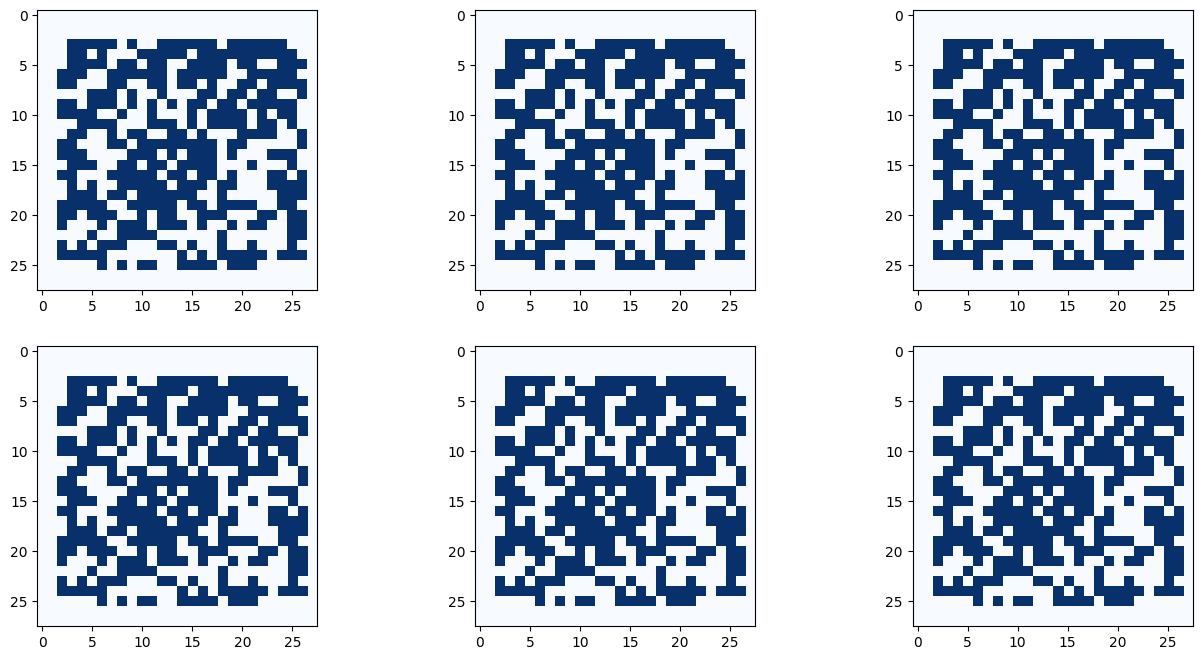

In [ ]:
G.plot_images(1)

- 학습되지 않는 것을 볼 수 있음
  - 책에서는 쉽게 설명하기위해 학습 방법을 3단계로 분류했지만 실제로는 그렇지 않음

### 2. 실제 예시들 참고
  - Kaggle
    - [Vanilla GAN on Fashion MNIST](https://www.kaggle.com/code/zorroblue/vanilla-gan-on-fashion-mnist)
    - [PyTorch Conditional GAN](https://www.kaggle.com/code/arturlacerda/pytorch-conditional-gan)
      - Variable == Tensor ( torch 0.4 버전 이후로 차이 없음 )

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.label_emb = nn.Embedding(10, 10)
        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(784+10, 1024), # 레이블 텐서 추가
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(1024),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(512),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.LayerNorm(256),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), 784) # Flatten
        # labels = self.label_emb(labels)
        x = torch.cat([x, labels], 1) # concat
        out = self.model(x)
        return out.squeeze()

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.label_emb = nn.Embedding(10, 10)
        self.latent_size = 500
        self.model = nn.Sequential(
            nn.Linear(self.latent_size + 10, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, 784),
            nn.Tanh()
        )
    def forward(self, z, labels):
        z = z.view(z.size(0), self.latent_size)
        # labels = self.label_emb(labels)
        x = torch.cat([z, labels], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

    # 주어진 조건에 맞는 이미지 생성 함수
    def plot_images(self, label):
        label_tensor = torch.zeros((1, 10))
        label_tensor[0][label] = 1.0
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(self.forward(generate_random_seed((1, self.latent_size)), label_tensor).detach().cpu().numpy(), interpolation='none', cmap='Blues')

In [15]:
G = Generator().cuda()
D = Discriminator().cuda()

criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)

In [16]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    labels = nn.functional.one_hot(labels, num_classes=len(class_list))
    real_validity = D(real_images, labels)
    real_loss = criterion(real_validity, torch.ones(batch_size).cuda()) #

    # train with fake images
    z = generate_random_seed((batch_size, generator.latent_size))
    fake_labels = generate_random_one_hot([batch_size, 10])
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, torch.zeros(batch_size).cuda())

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [17]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = generate_random_seed((batch_size, generator.latent_size))
    fake_labels = generate_random_one_hot([batch_size, 10])
    fake_images = generator(z, fake_labels)

    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, torch.ones(batch_size).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

Starting epoch 0...
g_loss: 7.721768856048584, d_loss: 0.0005458098603412509


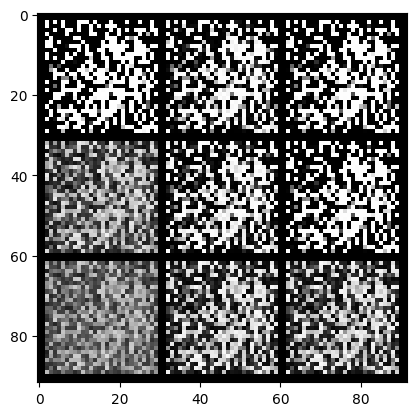

Starting epoch 1...
g_loss: 8.133052825927734, d_loss: 0.0027269788552075624


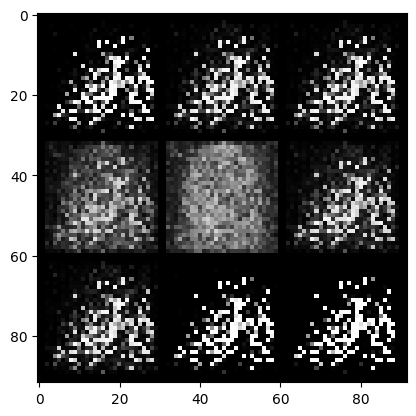

Starting epoch 2...
g_loss: 6.820143699645996, d_loss: 0.010545711033046246


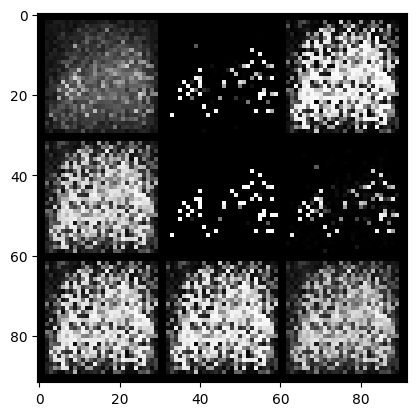

Starting epoch 3...
g_loss: 6.854508876800537, d_loss: 0.012678069062530994


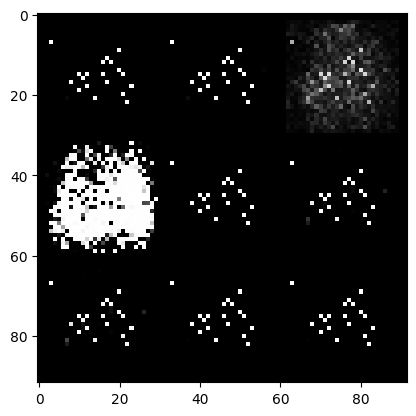

Starting epoch 4...
g_loss: 5.547738552093506, d_loss: 0.04664129018783569


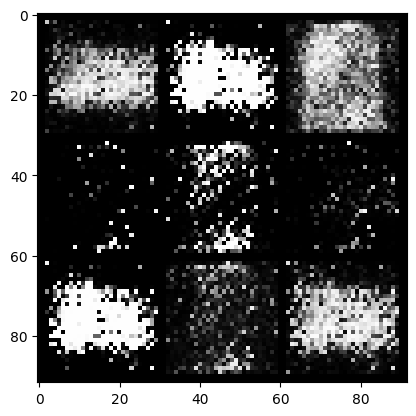

Starting epoch 5...
g_loss: 5.577771186828613, d_loss: 0.04403700307011604


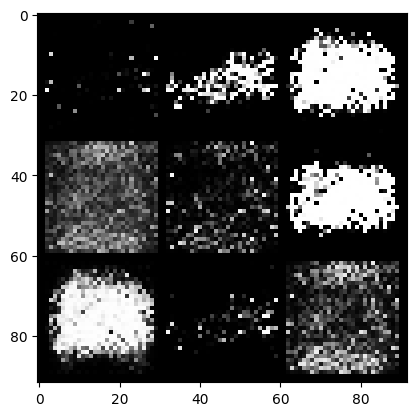

Starting epoch 6...
g_loss: 5.8180060386657715, d_loss: 0.09386561065912247


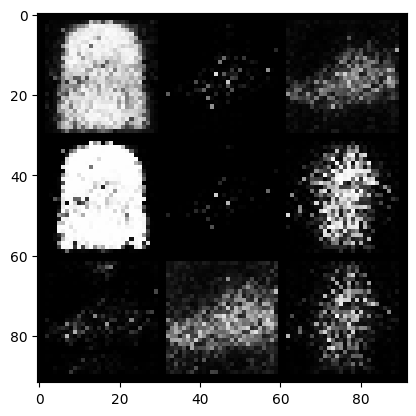

Starting epoch 7...
g_loss: 5.66152286529541, d_loss: 0.0756281316280365


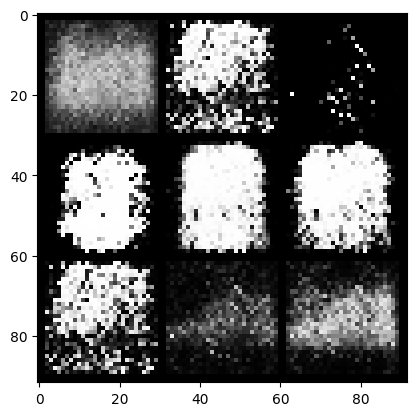

Starting epoch 8...
g_loss: 5.279750823974609, d_loss: 0.0929761528968811


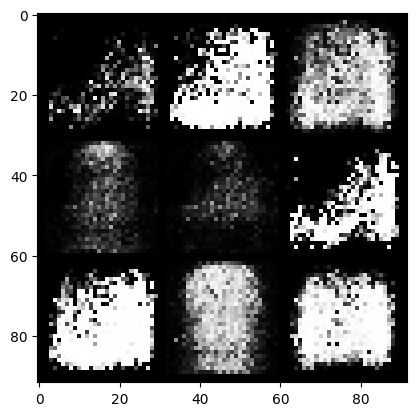

Starting epoch 9...
g_loss: 4.085960388183594, d_loss: 0.1902405470609665


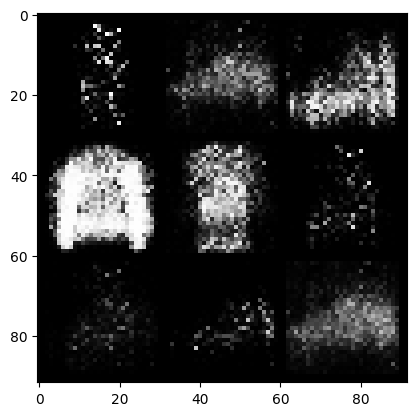

Starting epoch 10...
g_loss: 4.644351005554199, d_loss: 0.12871888279914856


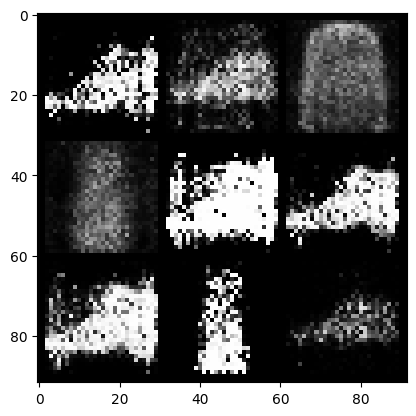

Starting epoch 11...
g_loss: 3.8945624828338623, d_loss: 0.19021041691303253


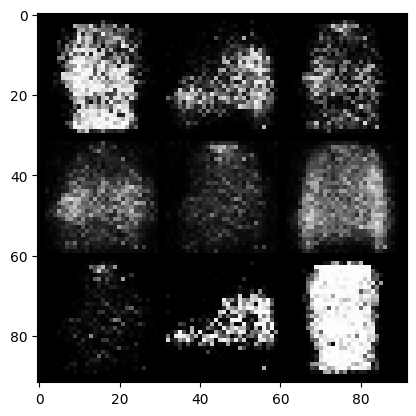

Starting epoch 12...
g_loss: 4.035277366638184, d_loss: 0.24317602813243866


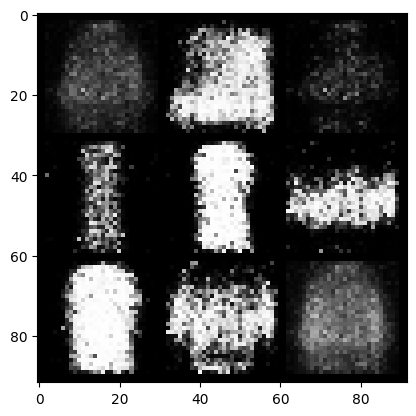

Starting epoch 13...
g_loss: 3.850877523422241, d_loss: 0.19625237584114075


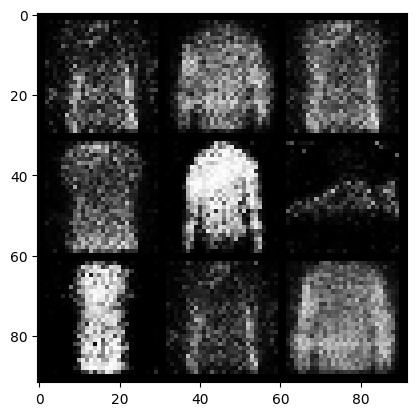

Starting epoch 14...
g_loss: 3.193397045135498, d_loss: 0.1597856730222702


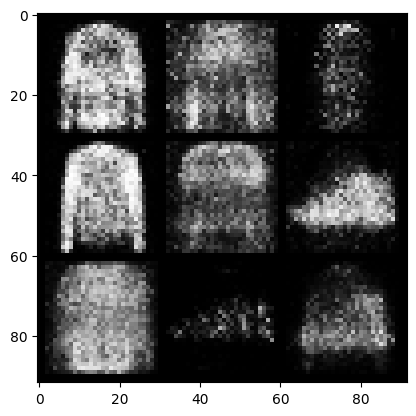

Starting epoch 15...
g_loss: 3.9877517223358154, d_loss: 0.17235329747200012


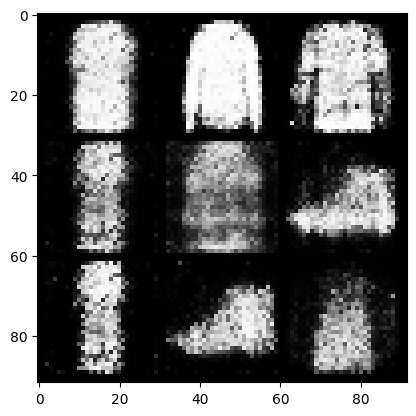

Starting epoch 16...
g_loss: 3.0006985664367676, d_loss: 0.2562873959541321


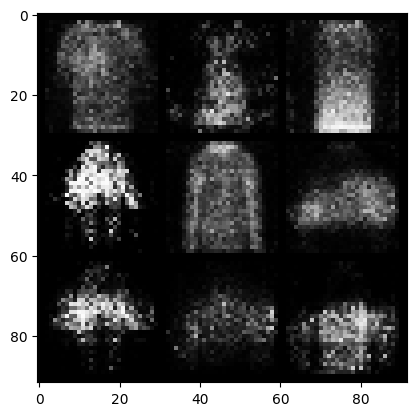

Starting epoch 17...
g_loss: 3.123570203781128, d_loss: 0.24845916032791138


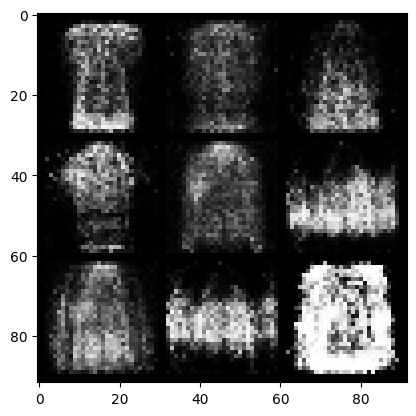

Starting epoch 18...
g_loss: 2.9916739463806152, d_loss: 0.21579156816005707


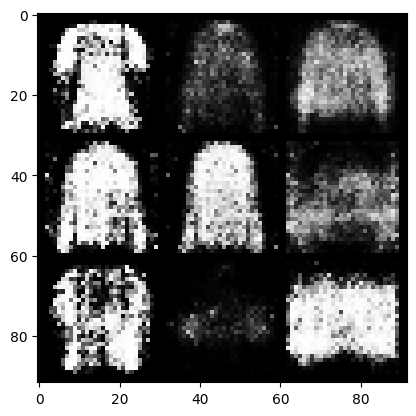

Starting epoch 19...
g_loss: 2.2679688930511475, d_loss: 0.3087030053138733


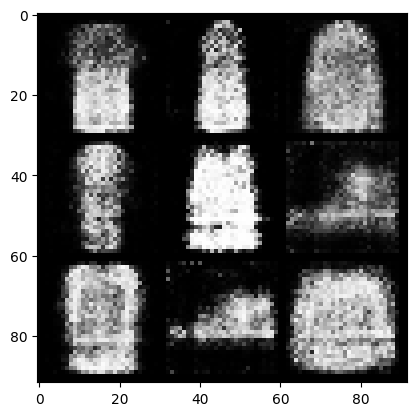

Starting epoch 20...
g_loss: 2.804171085357666, d_loss: 0.3151337504386902


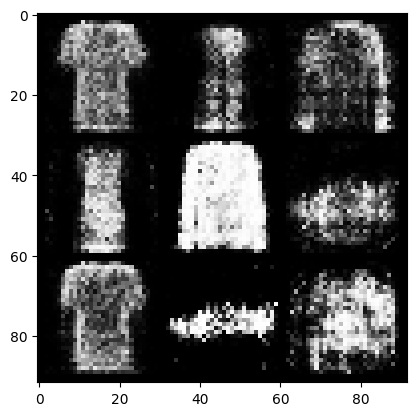

Starting epoch 21...
g_loss: 2.3905441761016846, d_loss: 0.3876446485519409


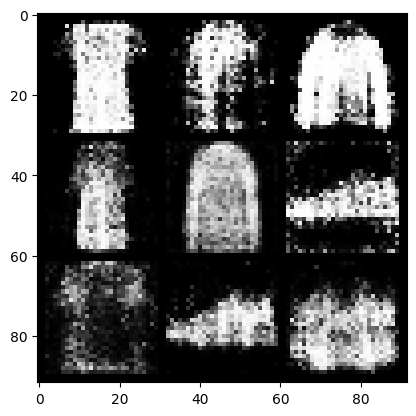

Starting epoch 22...
g_loss: 2.2583165168762207, d_loss: 0.33362579345703125


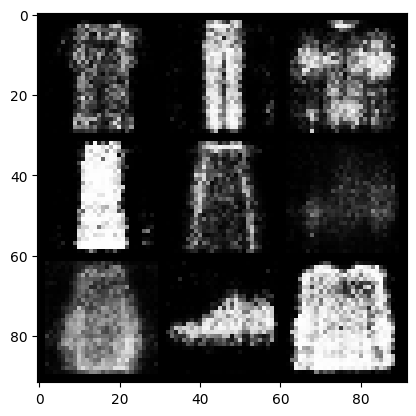

Starting epoch 23...
g_loss: 2.0050244331359863, d_loss: 0.24036623537540436


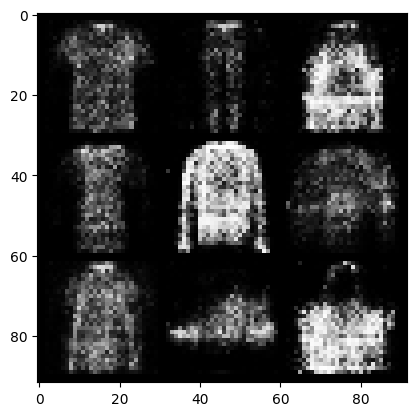

Starting epoch 24...
g_loss: 1.8200302124023438, d_loss: 0.5164074897766113


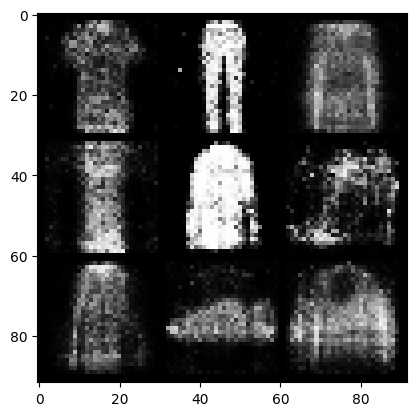

Starting epoch 25...
g_loss: 1.7497566938400269, d_loss: 0.3804435133934021


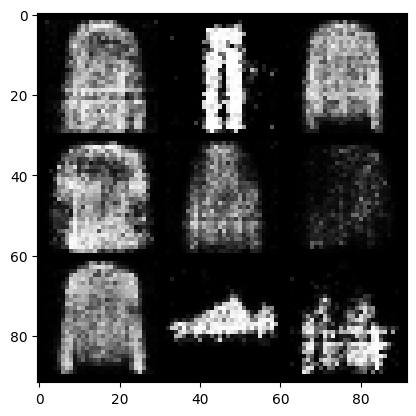

Starting epoch 26...
g_loss: 2.319175958633423, d_loss: 0.4299052953720093


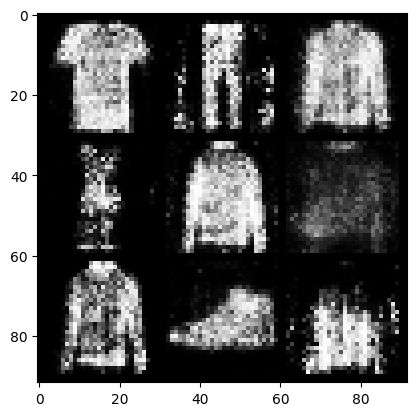

Starting epoch 27...
g_loss: 2.7430922985076904, d_loss: 0.20218749344348907


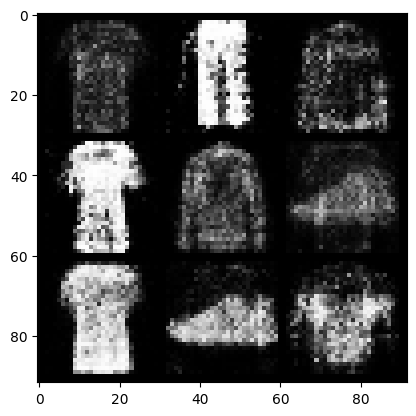

Starting epoch 28...
g_loss: 2.1983397006988525, d_loss: 0.3769776523113251


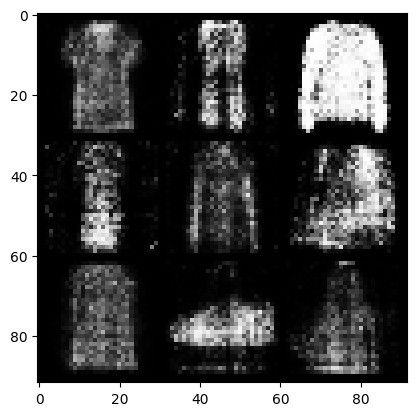

Starting epoch 29...
g_loss: 1.9765188694000244, d_loss: 0.42430877685546875


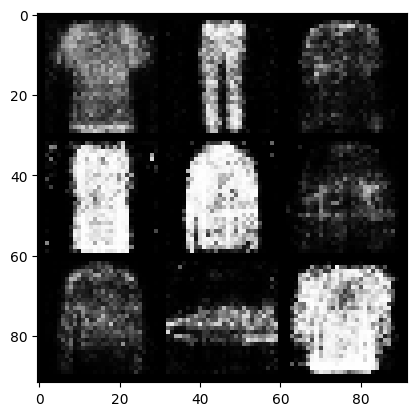

Starting epoch 30...
g_loss: 2.4462857246398926, d_loss: 0.3281714916229248


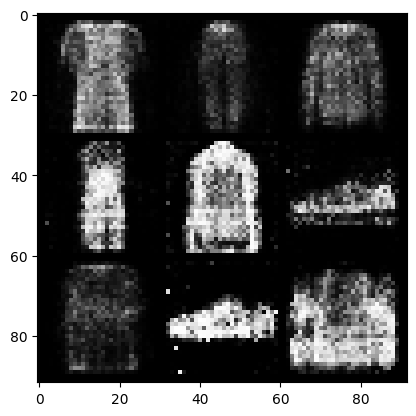

Starting epoch 31...
g_loss: 2.0504021644592285, d_loss: 0.3101780414581299


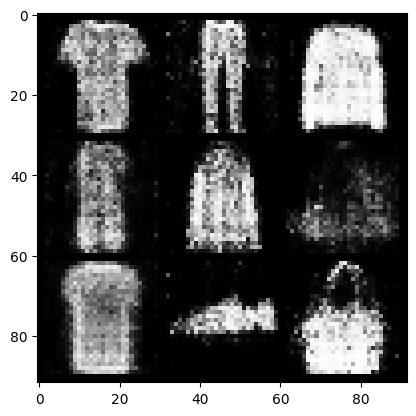

Starting epoch 32...
g_loss: 2.2890162467956543, d_loss: 0.2718806266784668


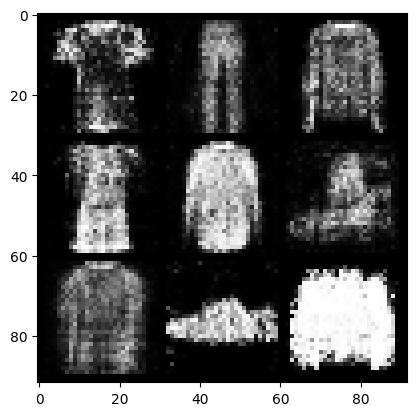

Starting epoch 33...
g_loss: 1.8438653945922852, d_loss: 0.5115337371826172


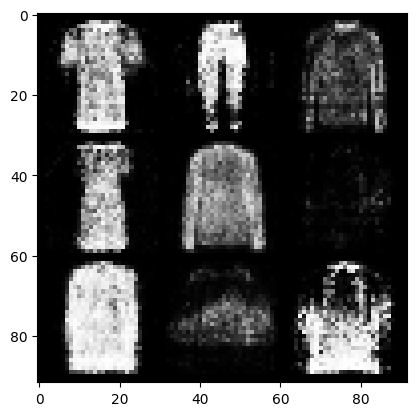

Starting epoch 34...
g_loss: 1.8698902130126953, d_loss: 0.36254948377609253


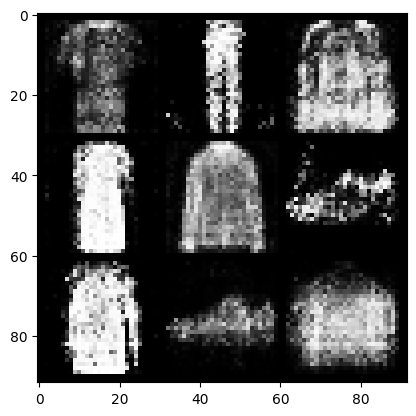

Starting epoch 35...
g_loss: 2.1878108978271484, d_loss: 0.34022051095962524


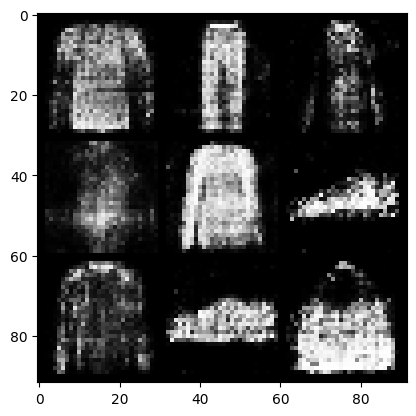

Starting epoch 36...
g_loss: 2.2812070846557617, d_loss: 0.3176340162754059


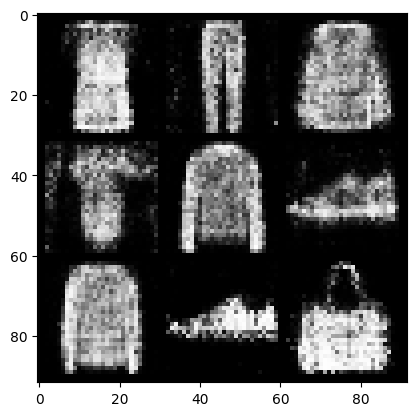

Starting epoch 37...
g_loss: 1.7325515747070312, d_loss: 0.5557230710983276


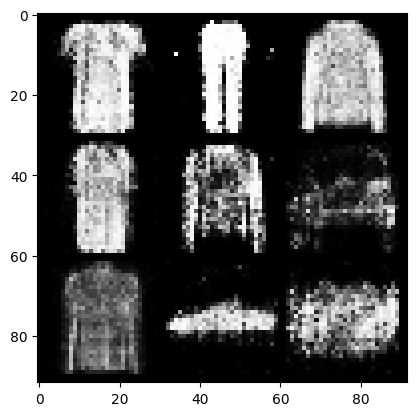

Starting epoch 38...
g_loss: 1.8778060674667358, d_loss: 0.3449791669845581


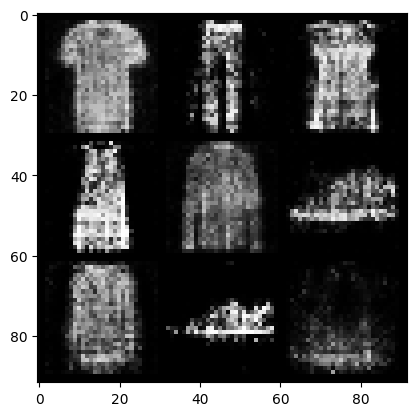

Starting epoch 39...
g_loss: 1.748155951499939, d_loss: 0.4471442997455597


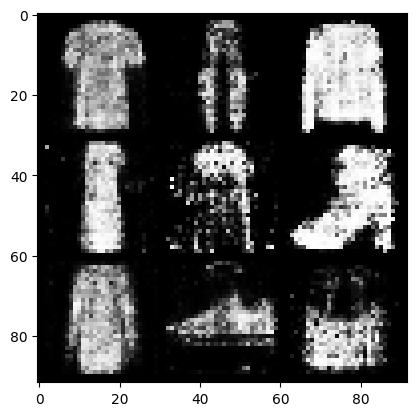

Starting epoch 40...
g_loss: 1.6365084648132324, d_loss: 0.5565698146820068


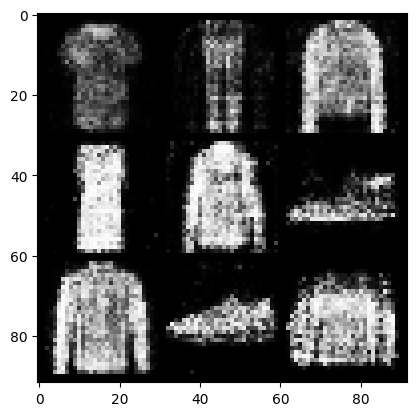

Starting epoch 41...
g_loss: 1.5129998922348022, d_loss: 0.5095897912979126


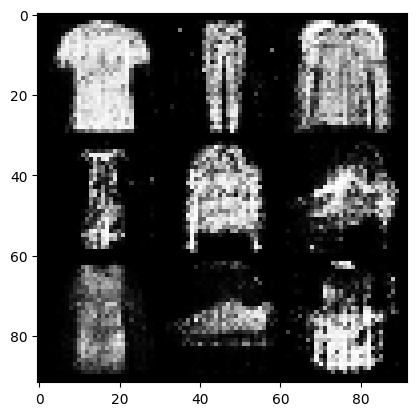

Starting epoch 42...
g_loss: 1.589951992034912, d_loss: 0.4047078490257263


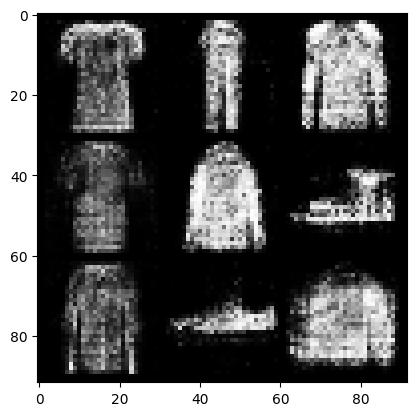

Starting epoch 43...
g_loss: 1.6089458465576172, d_loss: 0.5039637088775635


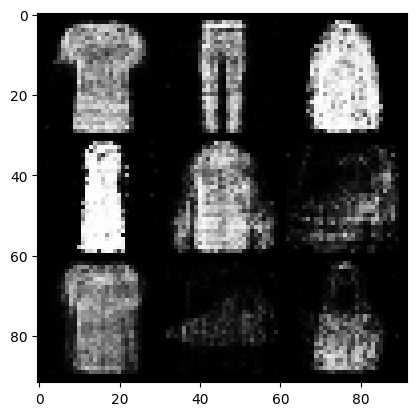

Starting epoch 44...
g_loss: 1.759579062461853, d_loss: 0.4040006995201111


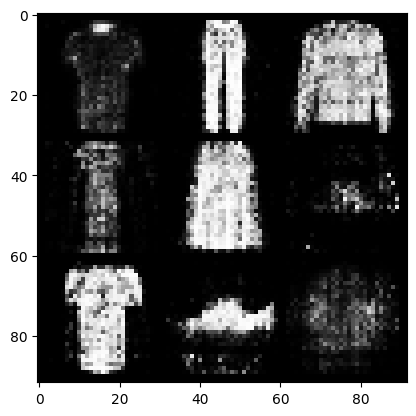

Starting epoch 45...
g_loss: 1.5529584884643555, d_loss: 0.4787181317806244


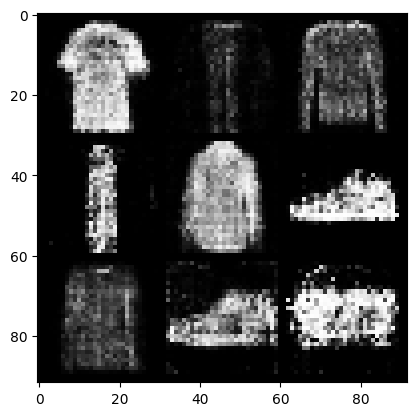

Starting epoch 46...
g_loss: 1.7994029521942139, d_loss: 0.4477589726448059


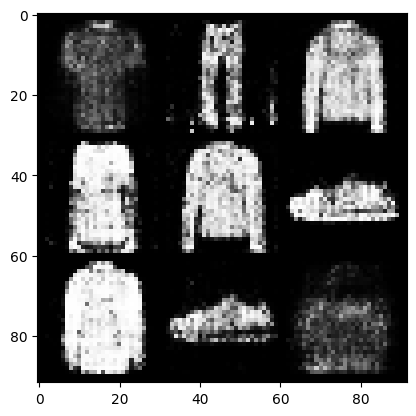

Starting epoch 47...
g_loss: 1.4750571250915527, d_loss: 0.44625324010849


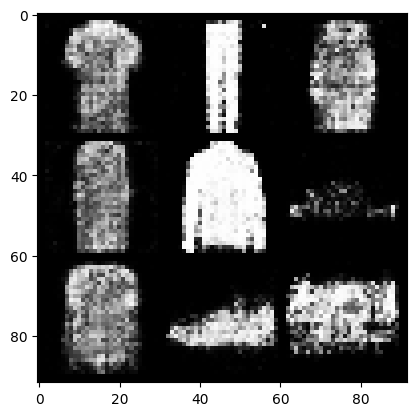

Starting epoch 48...
g_loss: 1.4901957511901855, d_loss: 0.5204859375953674


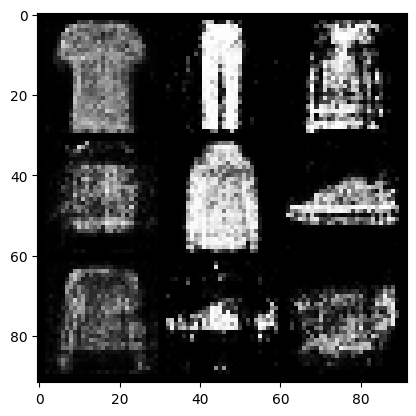

Starting epoch 49...
g_loss: 1.6348727941513062, d_loss: 0.49996864795684814


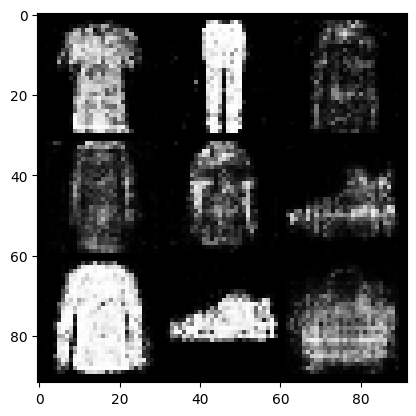

CPU times: user 18min 23s, sys: 9.08 s, total: 18min 32s
Wall time: 18min 54s


In [19]:
%%time

num_epochs = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(trainloader):
        real_images = images.cuda()
        labels = labels.cuda()
        G.train()
        d_loss = discriminator_train_step(len(real_images), D,
                                          G, d_optimizer, criterion,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, D, G, g_optimizer, criterion)

    G.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

    z = torch.randn(9, G.latent_size).cuda()
    labels = torch.LongTensor(np.arange(9)).cuda()
    labels = nn.functional.one_hot(labels, num_classes=len(class_list))
    sample_images = G(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

### Loss 변경
- Least Square Loss

In [20]:
G = Generator().cuda()
D = Discriminator().cuda()

d_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)

In [21]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    labels = nn.functional.one_hot(labels, num_classes=len(class_list))
    real_validity = D(real_images, labels) # D(x)
    real_loss = criterion(real_validity, torch.ones(batch_size).cuda()) #

    # train with fake images
    z = generate_random_seed((batch_size, generator.latent_size))
    fake_labels = generate_random_one_hot([batch_size, 10])
    fake_images = generator(z, fake_labels) # G(z)
    fake_validity = discriminator(fake_images, fake_labels) # D(G(z))
    fake_loss = torch.mean((real_validity - 1) ** 2) + torch.mean(fake_validity ** 2)

    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [22]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer):
    g_optimizer.zero_grad()
    z = generate_random_seed((batch_size, generator.latent_size))
    fake_labels = generate_random_one_hot([batch_size, 10])
    fake_images = generator(z, fake_labels)

    validity = discriminator(fake_images, fake_labels)
    g_loss = torch.mean((validity - 1) ** 2)
    g_loss.backward()
    g_optimizer.step()
    return g_loss.item()

Starting epoch 0...
g_loss: 0.9886542558670044, d_loss: 0.00018164028006140143


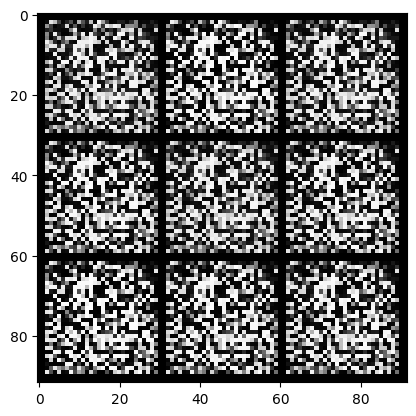

Starting epoch 1...
g_loss: 0.9976156949996948, d_loss: 0.0001176957375719212


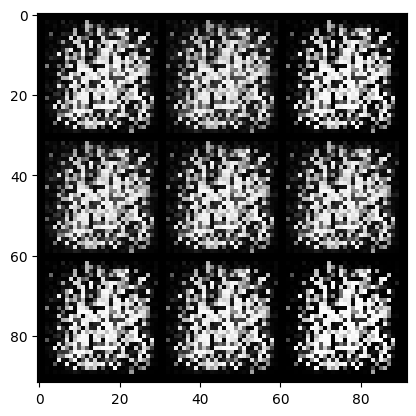

Starting epoch 2...
g_loss: 0.9960455894470215, d_loss: 0.026577740907669067


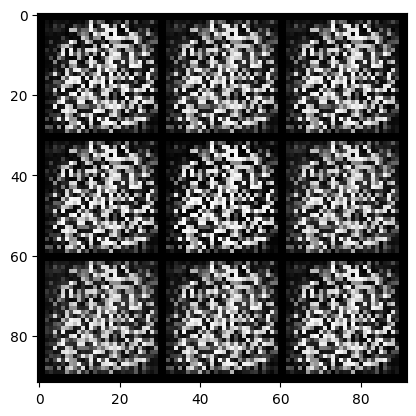

Starting epoch 3...
g_loss: 0.9897119402885437, d_loss: 0.0001157099541160278


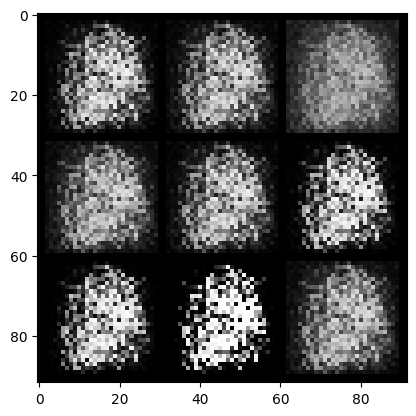

Starting epoch 4...
g_loss: 0.9995193481445312, d_loss: 3.8862195651745424e-05


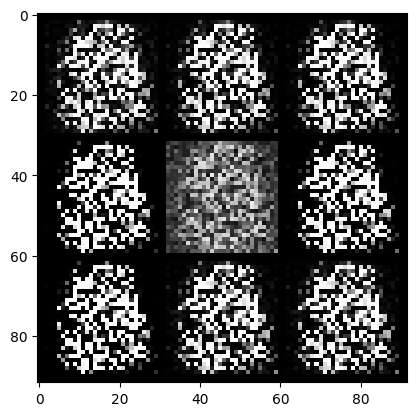

Starting epoch 5...
g_loss: 0.9993888139724731, d_loss: 2.3812050130800344e-05


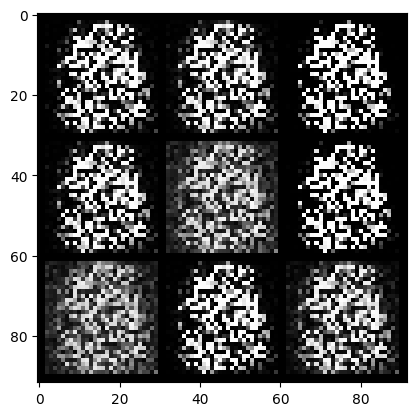

Starting epoch 6...
g_loss: 0.9988781809806824, d_loss: 1.946164593391586e-05


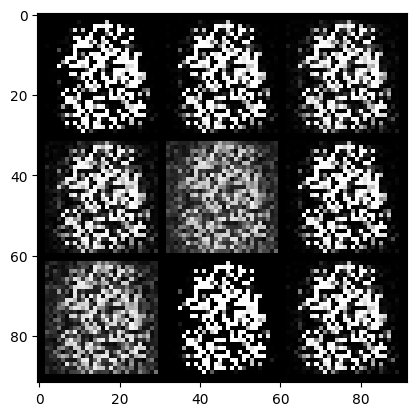

Starting epoch 7...
g_loss: 0.998665988445282, d_loss: 8.776791219133884e-05


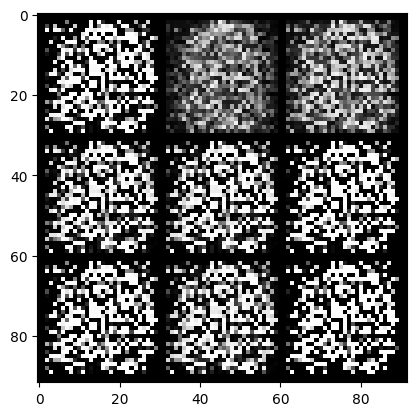

Starting epoch 8...
g_loss: 0.9993340373039246, d_loss: 3.94079543184489e-05


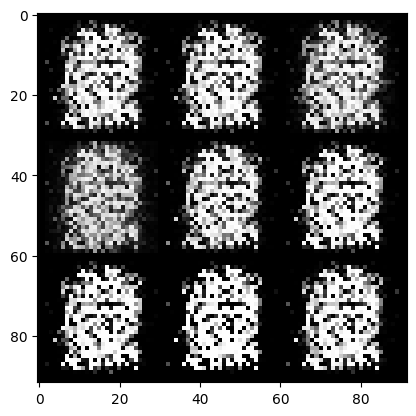

Starting epoch 9...
g_loss: 0.9429805278778076, d_loss: 0.03777090460062027


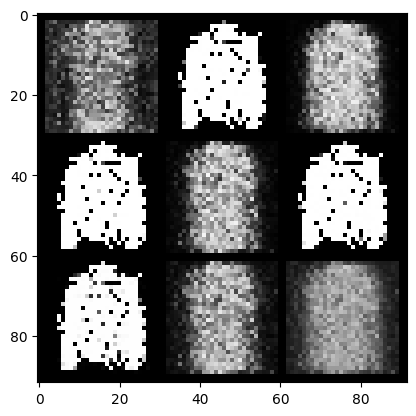

Starting epoch 10...
g_loss: 0.9928819537162781, d_loss: 0.01886051893234253


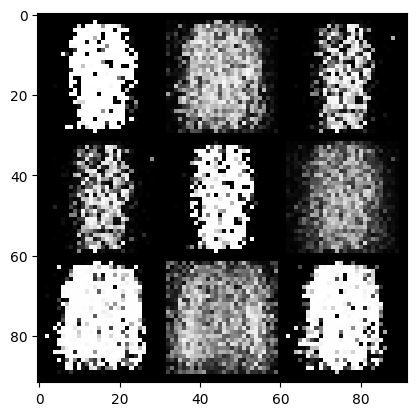

Starting epoch 11...
g_loss: 0.8858622908592224, d_loss: 0.08929689228534698


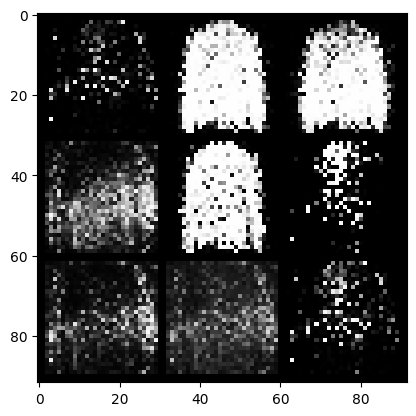

Starting epoch 12...
g_loss: 0.9438872337341309, d_loss: 0.036116354167461395


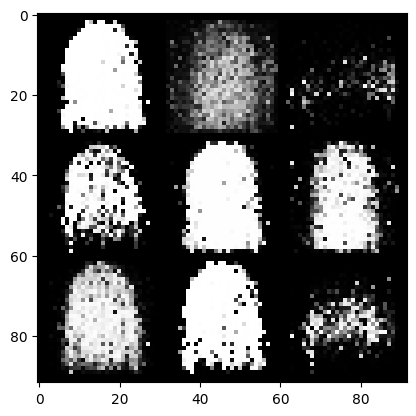

Starting epoch 13...
g_loss: 0.8815408945083618, d_loss: 0.09749336540699005


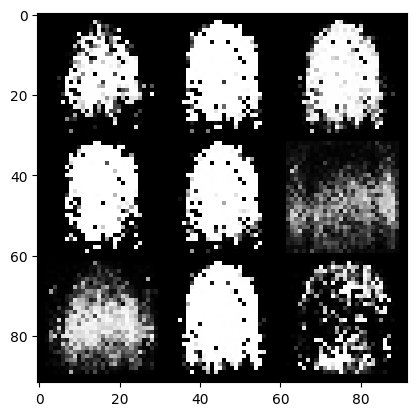

Starting epoch 14...
g_loss: 0.8387764692306519, d_loss: 0.0777788758277893


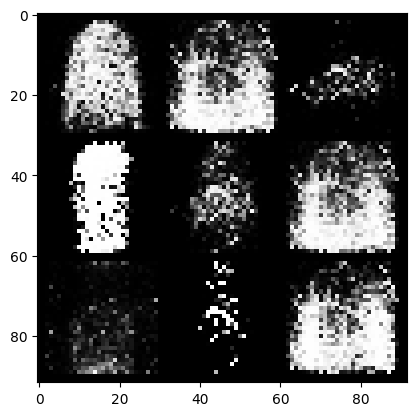

Starting epoch 15...
g_loss: 0.8426446914672852, d_loss: 0.05991547182202339


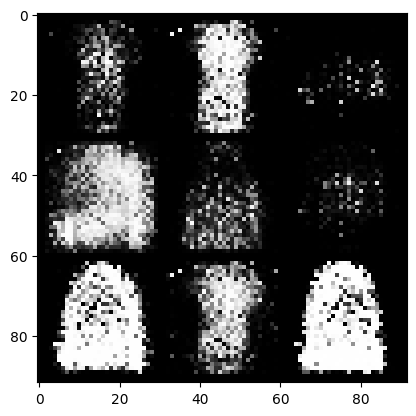

Starting epoch 16...
g_loss: 0.7503260970115662, d_loss: 0.12062470614910126


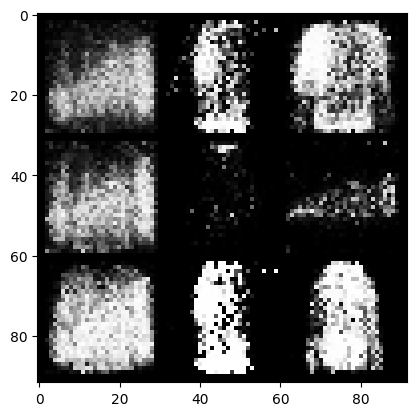

Starting epoch 17...
g_loss: 0.7209593653678894, d_loss: 0.11966992914676666


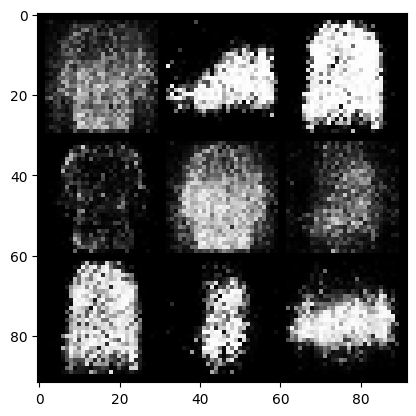

Starting epoch 18...
g_loss: 0.7113834619522095, d_loss: 0.08699194341897964


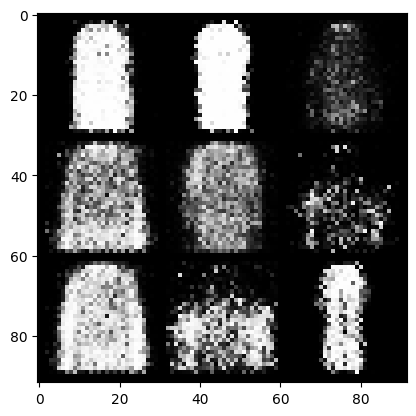

Starting epoch 19...
g_loss: 0.7059683799743652, d_loss: 0.1544436514377594


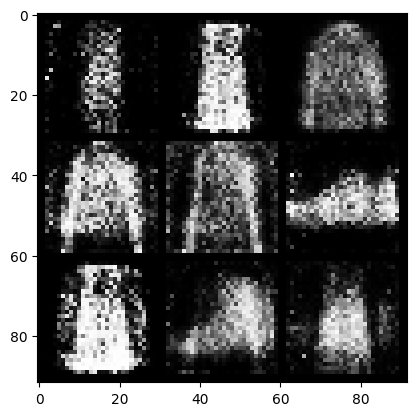

Starting epoch 20...
g_loss: 0.5228904485702515, d_loss: 0.21786049008369446


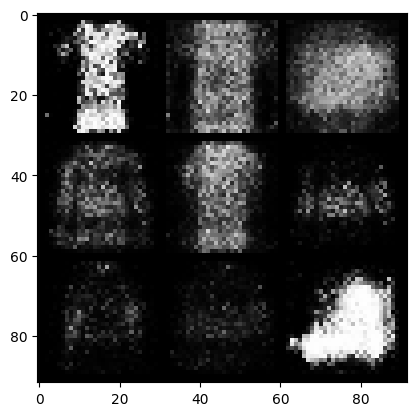

Starting epoch 21...
g_loss: 0.5859315991401672, d_loss: 0.14343248307704926


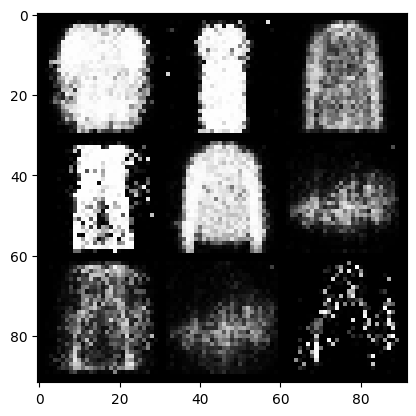

Starting epoch 22...
g_loss: 0.32951053977012634, d_loss: 0.27730298042297363


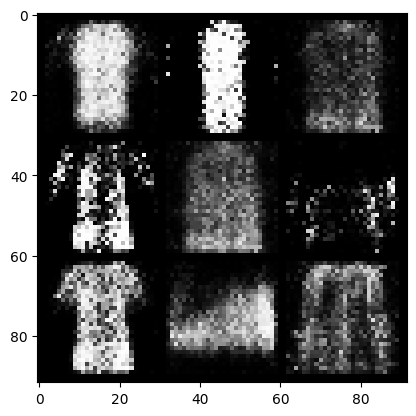

Starting epoch 23...
g_loss: 0.47250136733055115, d_loss: 0.20309722423553467


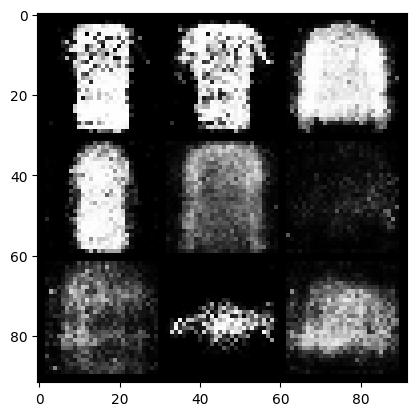

Starting epoch 24...
g_loss: 0.49068981409072876, d_loss: 0.16124401986598969


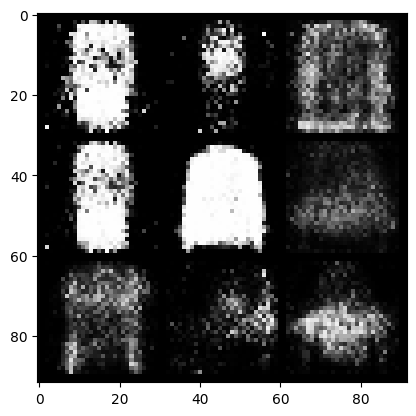

Starting epoch 25...
g_loss: 0.41956812143325806, d_loss: 0.38137730956077576


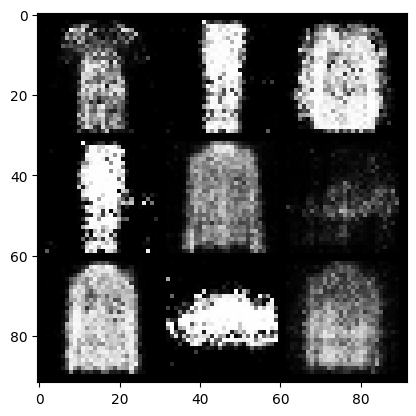

Starting epoch 26...
g_loss: 0.5407366752624512, d_loss: 0.19227848947048187


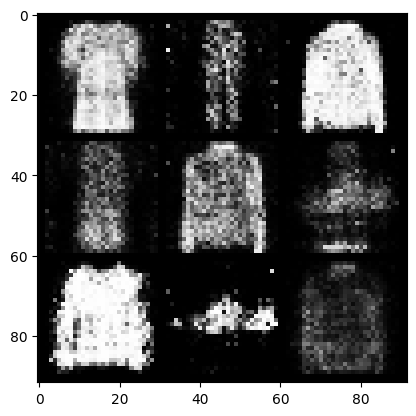

Starting epoch 27...
g_loss: 0.3114146888256073, d_loss: 0.2874312996864319


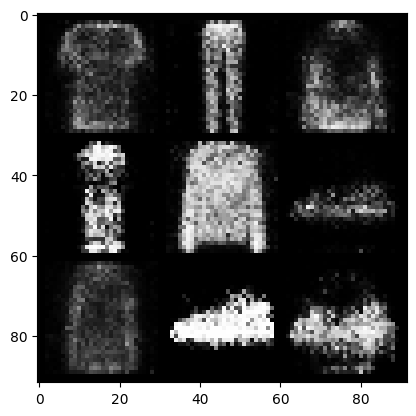

Starting epoch 28...
g_loss: 0.4824914336204529, d_loss: 0.19235090911388397


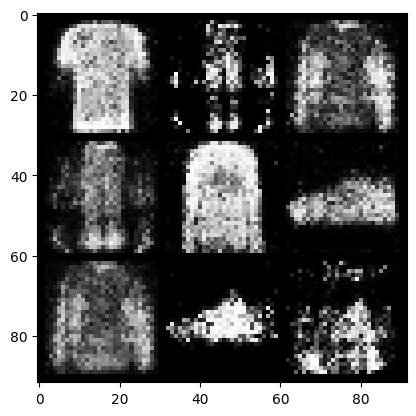

Starting epoch 29...
g_loss: 0.3838373124599457, d_loss: 0.1887197047472


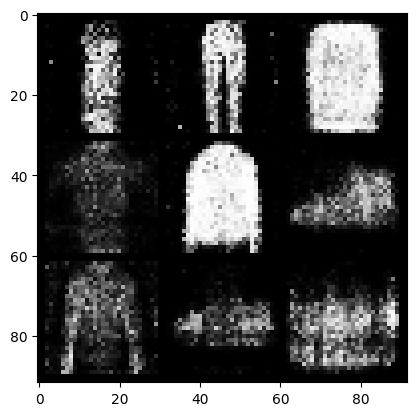

Starting epoch 30...
g_loss: 0.38531988859176636, d_loss: 0.29811346530914307


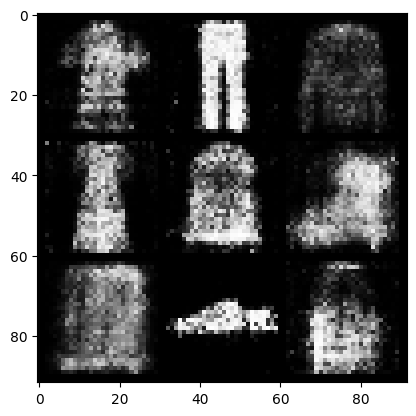

Starting epoch 31...
g_loss: 0.23561857640743256, d_loss: 0.2424204796552658


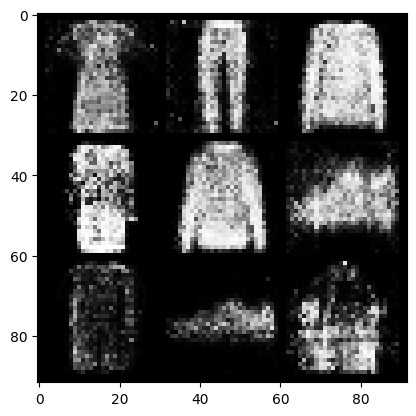

Starting epoch 32...
g_loss: 0.33366379141807556, d_loss: 0.32481735944747925


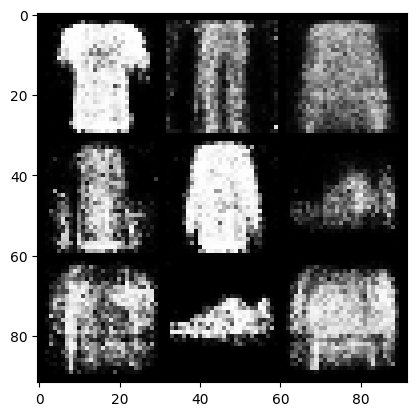

Starting epoch 33...
g_loss: 0.3948729932308197, d_loss: 0.23101884126663208


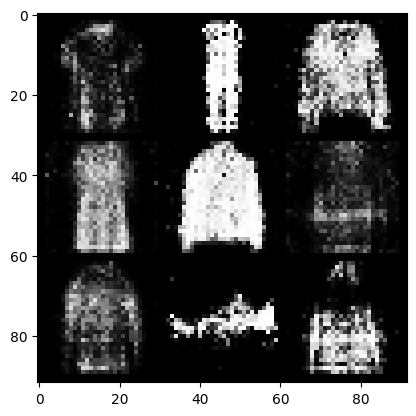

Starting epoch 34...
g_loss: 0.2880926728248596, d_loss: 0.23673346638679504


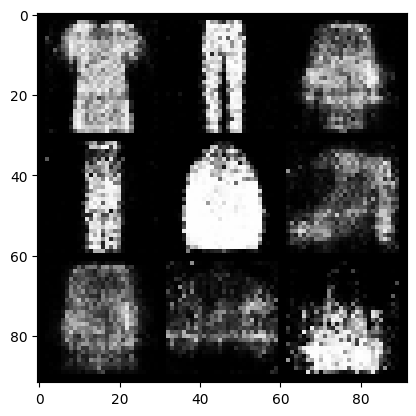

Starting epoch 35...
g_loss: 0.3173627257347107, d_loss: 0.3064466118812561


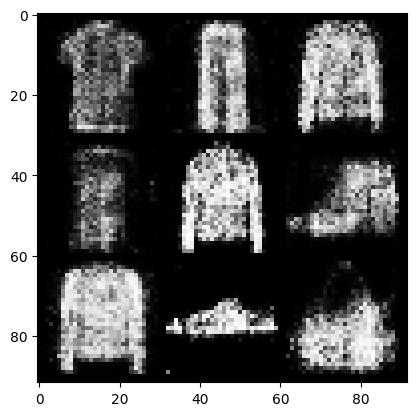

Starting epoch 36...
g_loss: 0.2808759808540344, d_loss: 0.2947108745574951


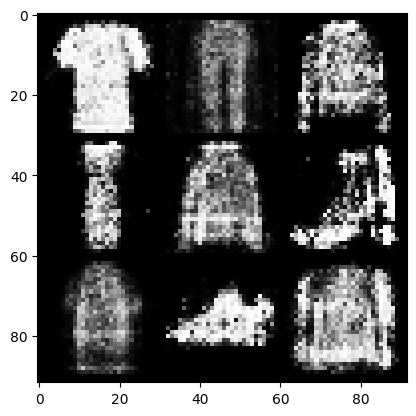

Starting epoch 37...
g_loss: 0.34021270275115967, d_loss: 0.2379501760005951


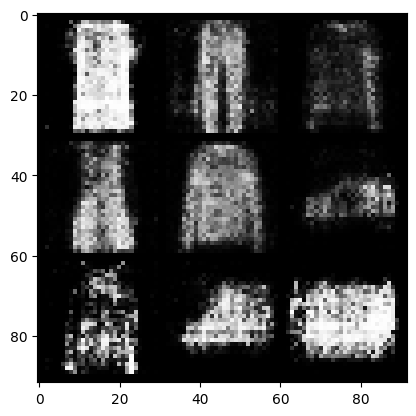

Starting epoch 38...
g_loss: 0.3952866494655609, d_loss: 0.2839955687522888


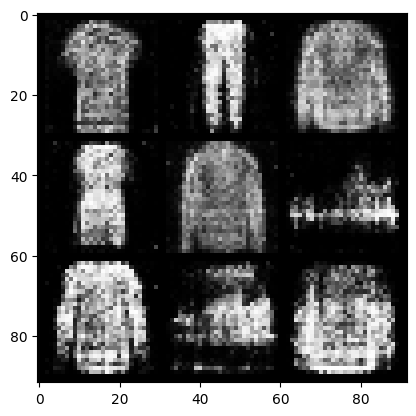

Starting epoch 39...
g_loss: 0.3047778010368347, d_loss: 0.36811017990112305


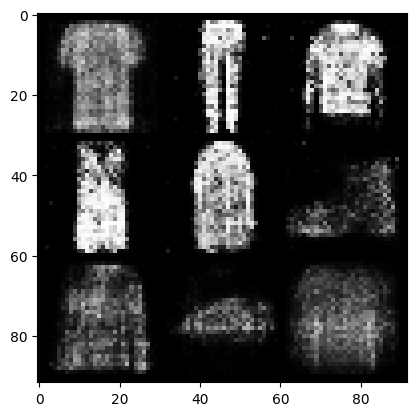

Starting epoch 40...
g_loss: 0.3992832601070404, d_loss: 0.20152804255485535


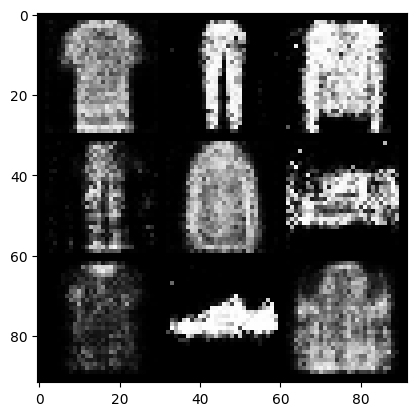

Starting epoch 41...
g_loss: 0.39573824405670166, d_loss: 0.3604586124420166


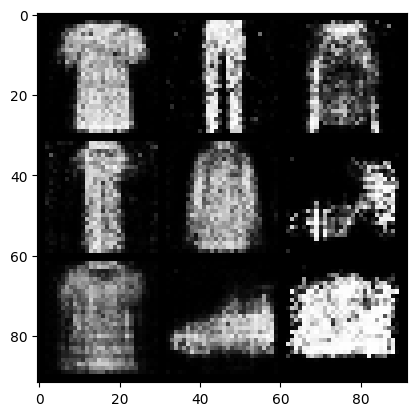

Starting epoch 42...
g_loss: 0.37602123618125916, d_loss: 0.2551656663417816


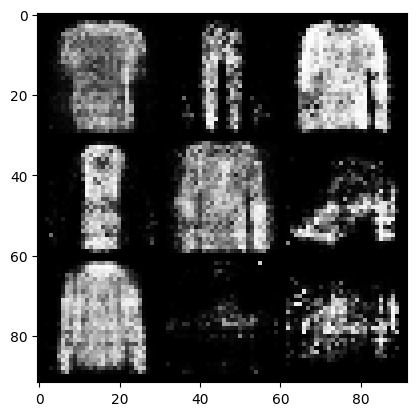

Starting epoch 43...
g_loss: 0.2974586486816406, d_loss: 0.28413212299346924


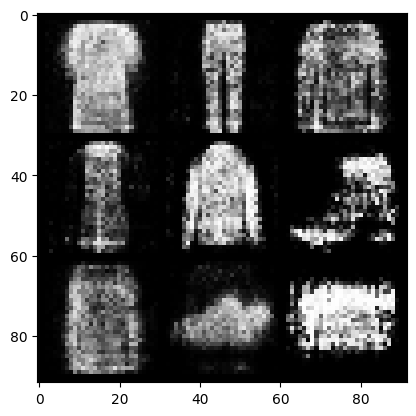

Starting epoch 44...
g_loss: 0.3906959891319275, d_loss: 0.2747536897659302


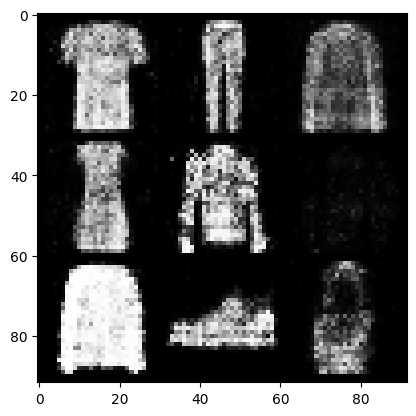

Starting epoch 45...
g_loss: 0.31878697872161865, d_loss: 0.3330213725566864


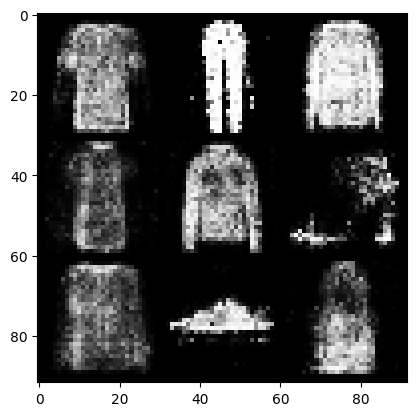

Starting epoch 46...
g_loss: 0.2808241546154022, d_loss: 0.250685453414917


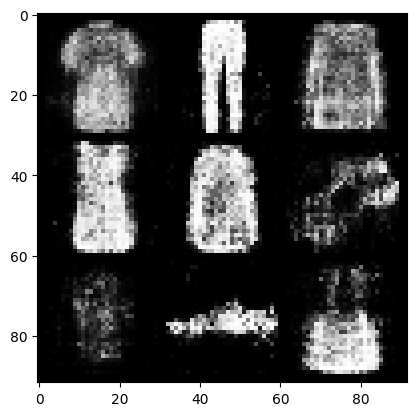

Starting epoch 47...
g_loss: 0.24821388721466064, d_loss: 0.36139780282974243


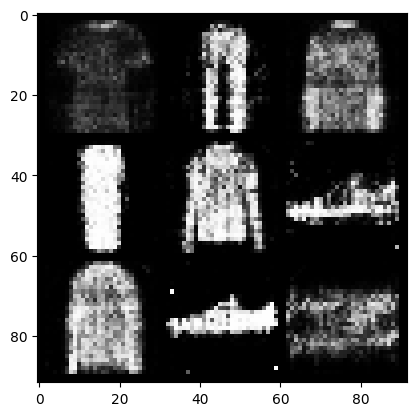

Starting epoch 48...
g_loss: 0.30890506505966187, d_loss: 0.2893182933330536


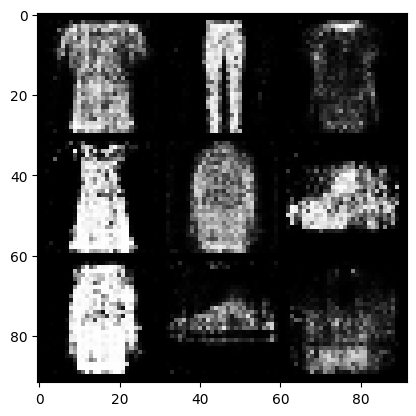

Starting epoch 49...
g_loss: 0.3004041314125061, d_loss: 0.26040661334991455


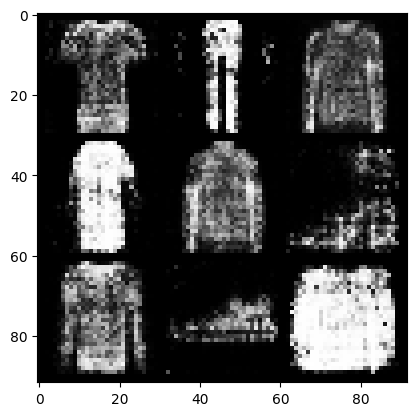

CPU times: user 19min 10s, sys: 9.37 s, total: 19min 19s
Wall time: 19min 35s


In [23]:
%%time

num_epochs = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(trainloader):
        real_images = images.cuda()
        labels = labels.cuda()
        G.train()
        d_loss = discriminator_train_step(len(real_images), D,
                                          G, d_optimizer,
                                          real_images, labels)


        g_loss = generator_train_step(batch_size, D, G, g_optimizer)

    G.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))

    z = torch.randn(9, G.latent_size).cuda()
    labels = torch.LongTensor(np.arange(9)).cuda()
    labels = nn.functional.one_hot(labels, num_classes=len(class_list))
    sample_images = G(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

# 성능 향상?
### 평가지표
- **IS (Inception Score)**
  - Inception모델에서 식별하기 쉬운 영상 및 식별된 레이블의 Variation(편차, 변화)이 풍부할수록 score가 높게 출력 되도록 설계
  - GAN의 성능평가에 두 가지 기준을 사용
    - 생성된 영상의 품질
    - 생성된 영상의 다양성
- **FID (Fréchet Inception Distance)**
  - GAN을 사용해 생성된 영상의 집합과 실제 생성하고자 하는 클래스 데이터의 분포의 거리를 계산
  - 거리가 가까울수록 좋은 영상으로 판단
  - IS 보다 노이즈에 강건함
  - 실제 이미지와 생성한 이미지의 분포가 정확하게 일치할 경우(FID가 0일 경우)가장 이상적인 모델이라고 판단할 수 있음
  - 평균적으로 FID가 10 내외이면 좋은 모델이라고 판단
- **1NNC (1-Nearest Neighbor classifier)**
  - 1-Nearest Neighbor 방법을 활용하여 LOO accuracy를 계산
    - Inception Score와 FID처럼 Inception Model을 사용하지 않음
  - hyperparameter없이 가장 효율적으로 GAN 모델을 평가
    - 3,5,7-Nearest Neighbor으로도 가능
  - 결과값 해석
    - LOO accuracy ≈ 0.5 : 가장 이상적인 경우
    - LOO accuracy < 0.5 : GAN이 실제 Image들에 Overfitting 됬다는 의미
    - LOO accuracy > 0.5 : GAN이 실제 Image들의 특성 분포를 잘 지니지 못한 Image를 생성했다는 의미
- **CID index**
  - CID = Creativity * Inheritance * Diversity  (3가지 평가지표를 곱한 지표)
    - Creativity : 실제 Image와 중복이 있으면 안됨
    - Inheritance : 생성된 Image는 같은 스타일을 가져야 함 (생성된 Image의 분포는 실제 Image의 분포에 가까워야됨)
    - Diversity : 생성된 Image들은 서로 달라야됨
- 참고자료
    - https://nippleshot.github.io/2020/12/25/GANMetric.html
    - https://m.blog.naver.com/chrhdhkd/222013835684
### 성능 향상 아이디어
- **DCGAN (Deep Convolutional GAN)**
  - Fully-Connected 구조를 CNN으로 변경
    - 생성자 모델에 Transposed Convolutional Network를 사용하여 Up-Sampling하는데 사용
    - 판별자 모델에는 단순 Convolutional Network를 사용
- **LSGAN (Least Square GAN)**
  - 단순히 loss 값만 변경하여 성능을 끌어올림
    - Sigmoid cross entropy loss의 Gradient Vanishing 문제
    - Sigmoid cross entropy loss → Least Square loss로 변경
- **PGGAN (Progressive Growing GAN)**
  - 크게 2가지 단점을 극복
    1. GAN을 고해상도로 만들면 판별자는 생성자가 생성한 이미지의 Real/Fake 여부를 구분하기 쉬워진다.
    2. 고해상도로 만들어도 메모리 제약조건으로 batch size를 줄여야하고 줄이면 학습과정이 불안정해진다
  - 4x4의 저해상도 이미지를 1024x1024 고해상도 이미지로 단계별(Progressive Growing)로 학습
    - 작은이미지 부터 고해상도 이미지까지 점진적으로 학습하여 안정성을 보장
- 참고자료
  - https://roytravel.tistory.com/109